# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Данный проект подрбно рассмотрен в видеокуре Глеба Михайлова, по которому учил Бустинг**

В данном проекте буду делать без учета наработок в его курсе

In [1]:
! pip install phik

     |████████████████████████████████| 679 kB 1.4 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time



# модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


from sklearn.linear_model import Ridge



# Вспомогательные методы
from sklearn.base import BaseEstimator
from sklearn.metrics import  make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split
# буст
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import lightgbm
import phik
from phik import resources, report


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


In [3]:
RAN_ST = 12345 # опредилим  random_state

In [4]:
df = pd.read_csv('/datasets/autos.csv')

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.duplicated().sum()

4

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
df['DateCrawled'] =  pd.to_datetime(df['DateCrawled']) # format='%Y%m%d:%H:%M:%S'
df['DateCrawled_Year']  = pd.DatetimeIndex(df['DateCrawled']).year
df['DateCrawled_Year'].value_counts()

2016    354365
Name: DateCrawled_Year, dtype: int64

In [11]:
df['DateCreated'] =  pd.to_datetime(df['DateCreated']) # format='%Y%m%d:%H:%M:%S'
df['DateCreated_Year']  = pd.DatetimeIndex(df['DateCreated']).year
df['DateCreated_Year'].value_counts()

2016    354339
2015        25
2014         1
Name: DateCreated_Year, dtype: int64

<AxesSubplot:>

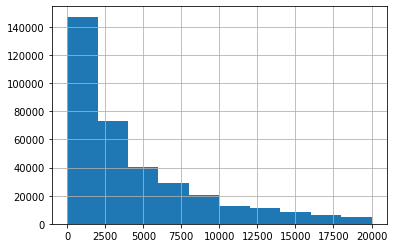

In [12]:
df['Price'].hist()

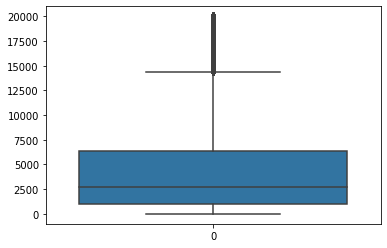

In [13]:
sns.boxplot(data=df['Price'])
plt.show()

 - Есть много пропущенных значений (необходима обоаботка) 
 - Явные дубликаты удалили
 - Явных выбросов в столбцу Price нет.
 - Есть столбцы, которы не несут смысла для модели - удалим.

<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - верное решение.
</div>

In [14]:
df.isna().sum()/df.shape[0]

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
Repaired             0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
DateCrawled_Year     0.000000
DateCreated_Year     0.000000
dtype: float64

In [15]:
df['Gearbox'].value_counts(normalize=True)
# df['Model'].value_counts()
# df['Repaired'].value_counts() #есть высокая вероятность, что пропущенные значения - это значит не чинили. 
#Но стопроцентной уверенности у меня нет

manual    0.801863
auto      0.198137
Name: Gearbox, dtype: float64

In [16]:
df['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64



1.LNG (Liquified Natural Gas) – сжиженный природный газ. Получают при охлаждении природного газа до температуры –160°C. При этом происходит сжатие газа по объему в 600 раз, а его вес уменьшается вдвое по сравнению с газообразным состоянием.

2.CNG (Compressed Natural Gas) – сжатый природный газ (метан): газообразные углеводороды, образующиеся в земной коре, высокоэкономичное энергетическое топливо.

3.LPG (Liquified Petroleum Gas) – сжиженный газ (пропан-бутан). Газ, полученный при добыче и переработке нефти. В жидкое состояние переводят при охлаждении до критической температуры и последующей конденсации в результате отвода теплоты парообразования.

4.SNG (Synthetic natural gas) – синтезированный природный газ (СПГ): газ, полученный из угля или нефти, состоит из тех же основных химических элементов, что и природный газ, и имеет такие же горючие свойства.
https://www.drive2.ru/l/3409061/

petrol и gasoline - это одно и тоже
https://otvet.mail.ru/question/34949627

In [17]:
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol').replace('lpg', 'gas').replace('cng', 'gas')

In [18]:
df['FuelType'].value_counts()

petrol      315068
gas           5875
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [19]:
#  Применим заглушку для пропущенных значений, т.к их змена может исазить данные
df['VehicleType'] = df['VehicleType'].fillna('undefined')
df['Gearbox'] = df['Gearbox'].fillna('undefined')
df['Model'] = df['Model'].fillna('undefined')
df['FuelType'] = df['FuelType'].fillna('undefined')
df['Repaired'] = df['Repaired'].fillna('undefined')

In [20]:
df['Repaired'].value_counts()

no           247158
undefined     71154
yes           36053
Name: Repaired, dtype: int64

In [21]:
#data.columns=data.columns.str.lower()  сначала изменил, потом не стал применять- падает наглядность

In [22]:
# Проверим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

In [23]:
df['RegistrationYear'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [24]:
pd.Series(list(df.RegistrationYear.unique())).sort_values(ascending=False)

67     9999
134    9996
119    9450
143    9229
91     9000
       ... 
102    1200
39     1111
133    1039
118    1001
70     1000
Length: 151, dtype: int64

In [25]:
pd.Series(list(df['DateCrawled_Year'].unique())).sort_values(ascending=False)

0    2016
dtype: int64

In [26]:
pd.Series(list(df['DateCreated_Year'].unique())).sort_values(ascending=False)

0    2016
1    2015
2    2014
dtype: int64

In [27]:
df=df.query('RegistrationYear >= 1950 & RegistrationYear < 2017') #исправил на 17

In [28]:
print("Колличество объявлений с нулевой ценой:",len(df.loc[df['Price'] == 0]))

Колличество объявлений с нулевой ценой: 9954


In [29]:
pd.Series(list(df.RegistrationYear.unique())).sort_values(ascending=False)

10    2016
31    2015
7     2014
27    2013
23    2012
      ... 
56    1954
64    1953
66    1952
63    1951
65    1950
Length: 67, dtype: int64

In [30]:
df=df.query('Price > 500')

In [31]:
#аномалии в мощности 
df['Power'].value_counts()

0        24452
75       19012
150      13320
140      12181
101      11595
         ...  
1701         1
560          1
678          1
8500         1
17019        1
Name: Power, Length: 649, dtype: int64

In [32]:
#df['Power'].dtypes

In [33]:
df[df['Power'] > 250]['Power'].count()

6925

In [34]:
df = df[df['Power'] < 250]

In [35]:
#Удалим столбцы, которые не будем использовать в модели
df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth', 'DateCrawled_Year', 'DateCreated_Year'], axis=1, inplace= True)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,undefined,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,undefined
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [36]:
# сбросим индексы
df = df.reset_index(drop=True)

<AxesSubplot:title={'center':'Зависимость цены от года'}, xlabel='RegistrationYear'>

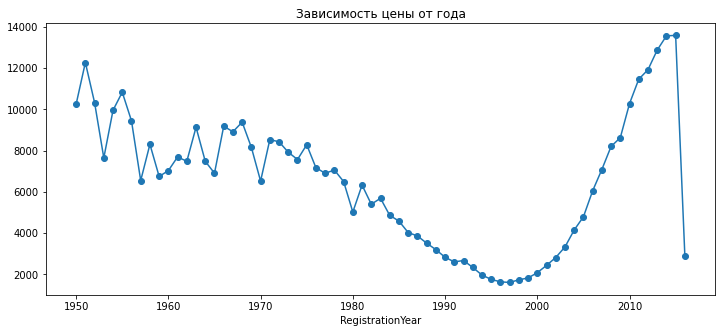

In [37]:
# for_plot = ['Age', 'Tenure', 'NumOfProducts', 'Exited']# df_plot = df[for_plot]
# sns.pairplot(df, hue='Price')
# actual_data.groupby('platform')['all_sales'].sum().sort_values(ascending=False).plot(figsize=(10,4),kind="bar",title='Продажи по платформам с 2016 года')
# #plt.ylim(0,3)
# sns.plot(x='RegistrationYear',y='Price', data=df)
# data.groupby('year_of_release')['name'].count().plot(x="year_of_release",style="-o",figsize=(10,6),title='Зависимость появления игр от года')
df.groupby('RegistrationYear')['Price'].mean().plot(x="year",style="-o",figsize=(12,5),title='Зависимость цены от года')

<div class="alert alert-block alert-info">
<b>Совет:</b> У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, супер-ретро, старая, новая... надо подумать..)..<br>


</div>

Сделал ниже

In [38]:
dt=df.copy()

In [39]:
dt['categ']=pd.qcut(dt['RegistrationYear'], 3, labels=["retro","old" , "new"]) #, [(1949.999, 2000.0] < (2000.0, 2005.0] < (2005.0, 2016.0]]
dt.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,categ
0,18300,coupe,2011,manual,190,undefined,125000,petrol,audi,yes,new
1,9800,suv,2004,auto,163,grand,125000,petrol,jeep,undefined,old
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,retro
3,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,new
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,retro


<AxesSubplot:title={'center':'Зависимость цены от категории'}, xlabel='categ'>

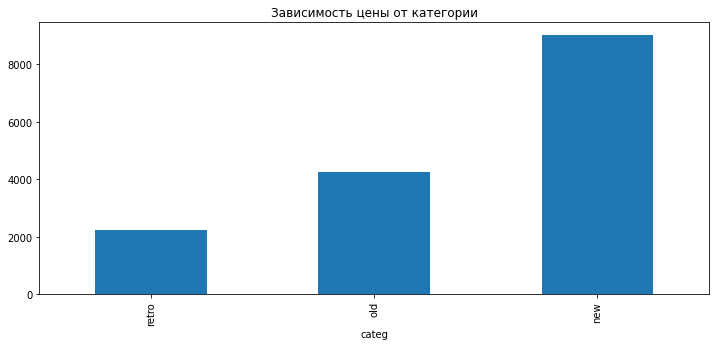

In [40]:
dt.groupby('categ')['Price'].mean().plot(kind = 'bar', figsize=(12,5),title='Зависимость цены от категории')

In [41]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.458402,0.431925,-0.393226
RegistrationYear,0.458402,1.000000,0.149096,-0.253609
Power,0.431925,0.149096,1.000000,0.094079
Kilometer,-0.393226,-0.253609,0.094079,1.000000


<AxesSubplot:>

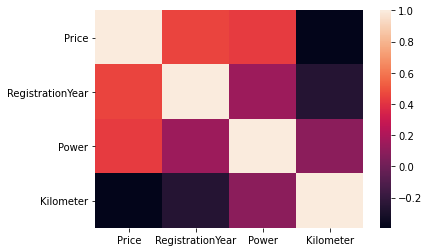

In [42]:
sns.heatmap(df.corr())

Линейной зависимости между признеками нет, надо использовать ML

In [43]:
df.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.248975,0.645675,0.258143,0.463415,0.559177,0.323697,0.102260,0.325010,0.280995
VehicleType,0.248975,1.000000,0.250622,0.456590,0.506761,0.898663,0.263503,0.319387,0.592766,0.380138
RegistrationYear,0.645675,0.250622,1.000000,0.113745,0.276842,0.626736,0.383659,0.099812,0.389547,0.156790
Gearbox,0.258143,0.456590,0.113745,1.000000,0.551002,0.608594,0.054435,0.380051,0.501404,0.394612
Power,0.463415,0.506761,0.276842,0.551002,1.000000,0.799740,0.140206,0.181919,0.600685,0.297813
Model,0.559177,0.898663,0.626736,0.608594,0.799740,1.000000,0.448552,0.368339,0.997899,0.268238
Kilometer,0.323697,0.263503,0.383659,0.054435,0.140206,0.448552,1.000000,0.092071,0.283961,0.202495
FuelType,0.102260,0.319387,0.099812,0.380051,0.181919,0.368339,0.092071,1.000000,0.245741,0.333722
Brand,0.325010,0.592766,0.389547,0.501404,0.600685,0.997899,0.283961,0.245741,1.000000,0.099716
Repaired,0.280995,0.380138,0.156790,0.394612,0.297813,0.268238,0.202495,0.333722,0.099716,1.000000


**Вывод по Главе: Подготовили данные для анализа.Рассмотрели каждый признак и исключили признаки, не имеющие для нас значения.**

## Обучение моделей

In [44]:
# # функция RMSE
# def rmse(target, predicted):
#     return mse(target, predicted) ** 0.5

In [45]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [46]:
df.shape[1]

10

In [47]:
# выделим категориальные признаки для простых моделей
cat_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType',  'Repaired']
num_features = ['RegistrationYear', 'Power', 'Kilometer']

In [48]:
data1=df.copy() #делаем копию для простых моделей
data2=df.copy() #делаем копию для catboost 

In [49]:
# Разделим признаки
features = data1.drop(columns='Price')
target = data1['Price']

In [50]:
# Подготовим  категориальные признаки с использованием OHE
features = pd.get_dummies(features, columns=cat_features, drop_first=True)
features.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_undefined,...,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_gas,FuelType_hybrid,FuelType_other,FuelType_petrol,FuelType_undefined,Repaired_undefined,Repaired_yes
0,2011,190,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2008,69,90000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1995,102,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


<div class="alert alert-block alert-success">
<b>Успех[2]:</b>  Хороши выбор
</div>


In [51]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RAN_ST)
print(features_train.shape[0]/features.shape[0], features_test.shape[0]/features.shape[0])

0.75 0.25



<div class="alert alert-block alert-danger">
    

<b>Ошибка:</b> `Стандартизирую численные признаки методомм Ordinal Encoding.` - это как?)
  
</div>
Исправил. (Забыл стереть :) )

In [52]:
# Проведем скалирование числовых признаков
scaler = StandardScaler()
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features]) 
#print(features_train.head())

/tmp/ipykernel_48/1373527936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[num_features] = scaler.transform(features_train[num_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_48/1373527936.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

**ПРОСТЫЕ МОДЕЛИ**

In [53]:
%%time
# Линейная регрессия
model_lr = LinearRegression()
rmse_lr_i = cross_val_score(model_lr,
                          features_train,
                          target_train,
                          scoring='neg_root_mean_squared_error',
                          cv=4)

rmse_lr = rmse_lr_i.mean()*-1

print('rmse_i:', rmse_lr_i)
print('rmse:', rmse_lr)

rmse_i: [-2707.39028289 -2674.72632659 -2662.0285768  -2677.04984254]
rmse: 2680.2987572044876
CPU times: user 33.7 s, sys: 15.6 s, total: 49.3 s
Wall time: 49.5 s


In [54]:
%%time

start = time.time()
model_lr.fit(features_train, target_train)
end = time.time()
t_lr_fit=round(end-start,2)

start = time.time()
target_predict = model_lr.predict(features_train)
end = time.time()
t_lr_pr=round(end-start,2)


# mse_lr = mse(target_train, target_predict, cv=4)
# rmse_lr= round((mse_lr) ** 0.5, 2) 
# print("RMSE для линейной модели на тестовой выборке:", rmse_lr)
#Было

CPU times: user 11.5 s, sys: 4.63 s, total: 16.1 s
Wall time: 16.1 s


In [55]:
%%time
# Дерево решений
model_tr = DecisionTreeRegressor(criterion='mse', random_state=RAN_ST)
param_grid_tr = {'max_depth': range(5, 20, 2)}
gs_tr = GridSearchCV(
    model_tr,
    cv=4,
    param_grid=param_grid_tr, 
    scoring='neg_root_mean_squared_error')
gs_tr.fit(features_train, target_train)

rmse_tr = gs_tr.best_score_ * -1                
print(f'best_score tree: {gs_tr.best_score_ * -1}')
print(f'best_params tree: {gs_tr.best_params_}')

best_score tree: 1837.6108144917732
best_params tree: {'max_depth': 17}
CPU times: user 1min 31s, sys: 5.41 s, total: 1min 36s
Wall time: 1min 36s


In [56]:
#gs_tr.cv_results_

In [57]:
# d=gs_tr.best_params_['max_depth']
# d

In [58]:
%%time
d_tr=gs_tr.best_params_['max_depth']

# Дерево решений с лучшими гиперпараметрами 
start = time.time()
model_tr = DecisionTreeRegressor(criterion='mse', max_depth=d_tr, random_state=RAN_ST)
model_tr.fit(features_train, target_train)
end = time.time()
t_tr_fit=round(end-start,2)

start = time.time()
target_predict = model_tr.predict(features_train)
end = time.time()
t_tr_pr=round(end-start,2)

#Было
# best_mse_model_tr  = 10_000_000
# d_tr =0
# for d in range(1, 16, 3):
#     model_tr = DecisionTreeRegressor(criterion='mse', max_depth=d, random_state=RAN_ST)
#     model_tr.fit(features_train, target_train)
#     preds_tr = model_tr.predict(features_test)
#     mse_model_tr = mean_squared_error(target_test, preds_tr)
    
    
#     if mse_model_tr < best_mse_model_tr:
#             best_mse_model_tr = mse_model_tr
#             d_tr = d

CPU times: user 4.97 s, sys: 296 ms, total: 5.27 s
Wall time: 5.44 s


In [59]:
# %%time

# # случайный лес

# model_fr = RandomForestRegressor(random_state=RAN_ST)
# param_grid_fr = {'n_estimators': range(80,100,10),'max_depth': range(10,16,3)}
# gs_fr = GridSearchCV(
#     model_fr,
#     cv=4,
#     param_grid=param_grid_fr, 
#     scoring='neg_root_mean_squared_error')
# gs_fr.fit(features_train, target_train)

# rmse_fr = gs_fr.best_score_ * -1                
# print(f'best_score RandomForest: {gs_fr.best_score_ * -1}')
# print(f'best_params RandomForest: {gs_fr.best_params_}')

# # best_score RandomForest: 1748.3586366743168
# # best_params RandomForest: {'max_depth': 13, 'n_estimators': 90}
# # CPU times: user 44min 24s, sys: 7.44 s, total: 44min 32s
# # Wall time: 44min 34s


Верхнюю ячейку посчитал, потом закоментировал, чтобы не ждать около часа при пересчете.

In [60]:
%%time

n_tr=90 #gs_fr.best_params_['n_estimators']
d_tr=13 #gs_fr.best_params_['max_depth']
# sl_tr=gs_fr.best_params_['min_samples_leaf']
# ss_tr=gs_fr.best_params_['min_samples_split']

# Лес с лучшими гиперпараметрами 
start = time.time()
model_fr = RandomForestRegressor(max_depth=d_tr, n_estimators=n_tr, random_state=RAN_ST)
model_fr.fit(features_train, target_train)
end = time.time()
t_fr_fit=round(end-start,2)

start = time.time()
target_predict = model_fr.predict(features_train)
end = time.time()
t_fr_pr=round(end-start,2)
rmse_fr = 1748              

CPU times: user 3min 53s, sys: 475 ms, total: 3min 54s
Wall time: 3min 54s


In [61]:
#было best_mse_model_fr=10_000_000
# d_fr=0
# n_fr=0
# for d in range(13, 14, 1):
#     for n in range(80, 90, 10):
#         model_fr = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=RAN_ST)
#         model_fr.fit(features_train, target_train)
#         preds_fr = model_fr.predict(features_test)
#         mse_model_fr = mean_squared_error(target_test, preds_fr)
       
#         if mse_model_fr < best_mse_model_fr:
#             best_mse_model_fr = mse_model_fr
#             d_fr = d
#             n_fr = n
            
    
# rmse_fr=round((best_mse_model_fr) ** 0.5, 2)            
# print("RMSE для RandomForest модели на тестовой выборке:", rmse_fr)            
# print('Гиперпараметры  -  max_depth:', d_fr, 'max_n_estimators:', n_fr) 
# # end = time.time()
# # t_fr=round(end-start,2)Лучшие параметры для RandomForest найдены за  1h 5min - поэтому сократил параметры в цикле. 

# Было:

# for d in range(5, 18, 1):

#     for n in range(50, 100, 5):


# RMSE для RandomForest модели на тестовой выборке: 1891.55
# Гиперпараметры  -  max_depth: 13 max_n_estimators: 80
# CPU times: user 1h 4min 36s, sys: 19.8 s, total: 1h 4min 56s
# Wall time: 1h 5min

**CatBoost**

In [62]:
# Разделим признаки для буста
features = data2.drop(columns='Price')
target = data2['Price']

In [63]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RAN_ST)
print(features_train.shape[0]/features.shape[0], features_test.shape[0]/features.shape[0])

0.75 0.25


In [79]:
%%time

# catboost
parameters = [{'learning_rate':[.1, .2], 'random_state':[12345]}]
model_cat = CatBoostRegressor(cat_features=cat_features) 
gscv = GridSearchCV(model_cat, parameters, scoring='neg_mean_squared_error', cv=3, verbose=100)
gscv.fit(features_train, target_train)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
rmse_cat =(max(mts) * -1) ** .5

print("RMSE для CatBoostRegressor модели на тестовой выборке:", rmse_cat )

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START learning_rate=0.1, random_state=12345.......................
0:	learn: 4122.3940310	total: 205ms	remaining: 3m 25s
1:	learn: 3872.0837627	total: 413ms	remaining: 3m 26s
2:	learn: 3654.0114607	total: 589ms	remaining: 3m 15s
3:	learn: 3453.5997387	total: 758ms	remaining: 3m 8s
4:	learn: 3279.9787113	total: 989ms	remaining: 3m 16s
5:	learn: 3125.7474599	total: 1.19s	remaining: 3m 16s
6:	learn: 2993.8512390	total: 1.33s	remaining: 3m 8s
7:	learn: 2876.9023113	total: 1.51s	remaining: 3m 7s
8:	learn: 2769.1522013	total: 1.68s	remaining: 3m 5s
9:	learn: 2676.3187016	total: 1.88s	remaining: 3m 6s
10:	learn: 2589.8937775	total: 2.07s	remaining: 3m 6s
11:	learn: 2520.5054841	total: 2.25s	remaining: 3m 5s
12:	learn: 2454.7688732	total: 2.46s	remaining: 3m 6s
13:	learn: 2398.8916122	total: 2.62s	remaining: 3m 4s
14:	learn: 2343.2581496	total: 2.78s	remaining: 3m 2s
15:	learn: 2299.5064095	total: 2.94s	remaining: 3m
16:	

148:	learn: 1683.2456788	total: 24.5s	remaining: 2m 20s
149:	learn: 1682.2412305	total: 24.7s	remaining: 2m 19s
150:	learn: 1681.4688178	total: 24.9s	remaining: 2m 19s
151:	learn: 1680.7964816	total: 25s	remaining: 2m 19s
152:	learn: 1680.0810708	total: 25.2s	remaining: 2m 19s
153:	learn: 1679.4533498	total: 25.4s	remaining: 2m 19s
154:	learn: 1678.4222491	total: 25.5s	remaining: 2m 19s
155:	learn: 1677.5012839	total: 25.7s	remaining: 2m 18s
156:	learn: 1677.0758164	total: 25.8s	remaining: 2m 18s
157:	learn: 1676.1303666	total: 26s	remaining: 2m 18s
158:	learn: 1675.1634280	total: 26.1s	remaining: 2m 18s
159:	learn: 1674.2656017	total: 26.3s	remaining: 2m 17s
160:	learn: 1673.5347941	total: 26.4s	remaining: 2m 17s
161:	learn: 1673.1862330	total: 26.6s	remaining: 2m 17s
162:	learn: 1672.4453225	total: 26.7s	remaining: 2m 17s
163:	learn: 1671.6506792	total: 26.9s	remaining: 2m 17s
164:	learn: 1670.7820405	total: 27.1s	remaining: 2m 17s
165:	learn: 1669.9066071	total: 27.3s	remaining: 2m 

297:	learn: 1614.5120565	total: 49s	remaining: 1m 55s
298:	learn: 1614.3019274	total: 49.1s	remaining: 1m 55s
299:	learn: 1614.1377857	total: 49.3s	remaining: 1m 54s
300:	learn: 1613.6239987	total: 49.4s	remaining: 1m 54s
301:	learn: 1613.4632625	total: 49.6s	remaining: 1m 54s
302:	learn: 1613.3737887	total: 49.7s	remaining: 1m 54s
303:	learn: 1613.1312335	total: 49.8s	remaining: 1m 54s
304:	learn: 1612.4726830	total: 50s	remaining: 1m 53s
305:	learn: 1612.2265961	total: 50.1s	remaining: 1m 53s
306:	learn: 1611.9285730	total: 50.3s	remaining: 1m 53s
307:	learn: 1611.4644382	total: 50.5s	remaining: 1m 53s
308:	learn: 1611.3231794	total: 50.6s	remaining: 1m 53s
309:	learn: 1610.7963089	total: 50.8s	remaining: 1m 52s
310:	learn: 1610.4331262	total: 51s	remaining: 1m 52s
311:	learn: 1610.3231116	total: 51.1s	remaining: 1m 52s
312:	learn: 1609.9725242	total: 51.3s	remaining: 1m 52s
313:	learn: 1609.6780405	total: 51.5s	remaining: 1m 52s
314:	learn: 1609.5661484	total: 51.6s	remaining: 1m 52

445:	learn: 1580.4986101	total: 1m 12s	remaining: 1m 30s
446:	learn: 1580.3838523	total: 1m 12s	remaining: 1m 30s
447:	learn: 1580.0740667	total: 1m 12s	remaining: 1m 29s
448:	learn: 1580.0605195	total: 1m 13s	remaining: 1m 29s
449:	learn: 1580.0192560	total: 1m 13s	remaining: 1m 29s
450:	learn: 1579.8658929	total: 1m 13s	remaining: 1m 29s
451:	learn: 1579.7587365	total: 1m 13s	remaining: 1m 29s
452:	learn: 1579.6742476	total: 1m 13s	remaining: 1m 28s
453:	learn: 1579.6161549	total: 1m 13s	remaining: 1m 28s
454:	learn: 1579.4798859	total: 1m 13s	remaining: 1m 28s
455:	learn: 1579.4158569	total: 1m 14s	remaining: 1m 28s
456:	learn: 1579.2530804	total: 1m 14s	remaining: 1m 28s
457:	learn: 1579.1712451	total: 1m 14s	remaining: 1m 28s
458:	learn: 1579.0960335	total: 1m 14s	remaining: 1m 27s
459:	learn: 1578.8292852	total: 1m 14s	remaining: 1m 27s
460:	learn: 1578.4244955	total: 1m 14s	remaining: 1m 27s
461:	learn: 1578.2081936	total: 1m 15s	remaining: 1m 27s
462:	learn: 1577.9425140	total:

590:	learn: 1558.4142324	total: 1m 36s	remaining: 1m 6s
591:	learn: 1558.2378695	total: 1m 36s	remaining: 1m 6s
592:	learn: 1558.1822934	total: 1m 36s	remaining: 1m 6s
593:	learn: 1558.1433828	total: 1m 36s	remaining: 1m 5s
594:	learn: 1558.0339697	total: 1m 36s	remaining: 1m 5s
595:	learn: 1557.9909986	total: 1m 36s	remaining: 1m 5s
596:	learn: 1557.8733638	total: 1m 36s	remaining: 1m 5s
597:	learn: 1557.3825383	total: 1m 37s	remaining: 1m 5s
598:	learn: 1557.3380552	total: 1m 37s	remaining: 1m 5s
599:	learn: 1557.0281398	total: 1m 37s	remaining: 1m 4s
600:	learn: 1556.9331408	total: 1m 37s	remaining: 1m 4s
601:	learn: 1556.7921959	total: 1m 37s	remaining: 1m 4s
602:	learn: 1556.6416126	total: 1m 37s	remaining: 1m 4s
603:	learn: 1556.5245563	total: 1m 37s	remaining: 1m 4s
604:	learn: 1556.2778748	total: 1m 38s	remaining: 1m 4s
605:	learn: 1556.1731215	total: 1m 38s	remaining: 1m 3s
606:	learn: 1556.1563331	total: 1m 38s	remaining: 1m 3s
607:	learn: 1556.0305584	total: 1m 38s	remaining

738:	learn: 1539.3069736	total: 2m	remaining: 42.5s
739:	learn: 1539.2742166	total: 2m	remaining: 42.3s
740:	learn: 1539.0227417	total: 2m	remaining: 42.2s
741:	learn: 1538.8238253	total: 2m	remaining: 42s
742:	learn: 1538.6150920	total: 2m	remaining: 41.8s
743:	learn: 1538.5169308	total: 2m 1s	remaining: 41.7s
744:	learn: 1538.4556542	total: 2m 1s	remaining: 41.5s
745:	learn: 1538.3911403	total: 2m 1s	remaining: 41.3s
746:	learn: 1538.1935205	total: 2m 1s	remaining: 41.2s
747:	learn: 1538.0349001	total: 2m 1s	remaining: 41s
748:	learn: 1537.8528730	total: 2m 1s	remaining: 40.9s
749:	learn: 1537.7776521	total: 2m 2s	remaining: 40.7s
750:	learn: 1537.7205188	total: 2m 2s	remaining: 40.6s
751:	learn: 1537.6148013	total: 2m 2s	remaining: 40.4s
752:	learn: 1537.5574168	total: 2m 2s	remaining: 40.2s
753:	learn: 1537.3995627	total: 2m 2s	remaining: 40.1s
754:	learn: 1537.1560252	total: 2m 3s	remaining: 39.9s
755:	learn: 1537.0088841	total: 2m 3s	remaining: 39.8s
756:	learn: 1536.9787605	tota

888:	learn: 1521.8956702	total: 2m 25s	remaining: 18.2s
889:	learn: 1521.7144318	total: 2m 25s	remaining: 18s
890:	learn: 1521.5690872	total: 2m 25s	remaining: 17.8s
891:	learn: 1521.5046409	total: 2m 25s	remaining: 17.7s
892:	learn: 1521.4050899	total: 2m 26s	remaining: 17.5s
893:	learn: 1521.3336477	total: 2m 26s	remaining: 17.3s
894:	learn: 1521.2278737	total: 2m 26s	remaining: 17.2s
895:	learn: 1521.0913263	total: 2m 26s	remaining: 17s
896:	learn: 1521.0818397	total: 2m 26s	remaining: 16.9s
897:	learn: 1521.0726060	total: 2m 27s	remaining: 16.7s
898:	learn: 1520.9801659	total: 2m 27s	remaining: 16.5s
899:	learn: 1520.9646787	total: 2m 27s	remaining: 16.4s
900:	learn: 1520.8853925	total: 2m 27s	remaining: 16.2s
901:	learn: 1520.7772485	total: 2m 27s	remaining: 16s
902:	learn: 1520.5593030	total: 2m 27s	remaining: 15.9s
903:	learn: 1520.3261388	total: 2m 27s	remaining: 15.7s
904:	learn: 1520.2860334	total: 2m 28s	remaining: 15.5s
905:	learn: 1520.1430911	total: 2m 28s	remaining: 15.4

34:	learn: 1910.2659414	total: 5.96s	remaining: 2m 44s
35:	learn: 1904.3090816	total: 6.13s	remaining: 2m 44s
36:	learn: 1897.0883400	total: 6.32s	remaining: 2m 44s
37:	learn: 1891.7640811	total: 6.49s	remaining: 2m 44s
38:	learn: 1886.3669917	total: 6.68s	remaining: 2m 44s
39:	learn: 1879.2284650	total: 6.76s	remaining: 2m 42s
40:	learn: 1874.0793803	total: 6.92s	remaining: 2m 41s
41:	learn: 1869.1842037	total: 7.12s	remaining: 2m 42s
42:	learn: 1862.0747608	total: 7.25s	remaining: 2m 41s
43:	learn: 1857.2007119	total: 7.41s	remaining: 2m 41s
44:	learn: 1852.4344682	total: 7.59s	remaining: 2m 41s
45:	learn: 1847.8301828	total: 7.71s	remaining: 2m 39s
46:	learn: 1845.0445482	total: 7.84s	remaining: 2m 39s
47:	learn: 1840.4991608	total: 8.06s	remaining: 2m 39s
48:	learn: 1837.1952377	total: 8.21s	remaining: 2m 39s
49:	learn: 1833.4394211	total: 8.38s	remaining: 2m 39s
50:	learn: 1830.7761817	total: 8.54s	remaining: 2m 38s
51:	learn: 1827.8005114	total: 8.71s	remaining: 2m 38s
52:	learn:

182:	learn: 1668.1874624	total: 29.2s	remaining: 2m 10s
183:	learn: 1667.8446957	total: 29.4s	remaining: 2m 10s
184:	learn: 1667.6146048	total: 29.5s	remaining: 2m 10s
185:	learn: 1667.3144252	total: 29.7s	remaining: 2m 10s
186:	learn: 1666.5608303	total: 29.9s	remaining: 2m 10s
187:	learn: 1665.9201437	total: 30.1s	remaining: 2m 9s
188:	learn: 1665.3746214	total: 30.3s	remaining: 2m 9s
189:	learn: 1664.8303575	total: 30.4s	remaining: 2m 9s
190:	learn: 1664.2427928	total: 30.6s	remaining: 2m 9s
191:	learn: 1663.6216383	total: 30.8s	remaining: 2m 9s
192:	learn: 1662.9762625	total: 30.9s	remaining: 2m 9s
193:	learn: 1662.5426372	total: 31.1s	remaining: 2m 9s
194:	learn: 1662.1612711	total: 31.2s	remaining: 2m 8s
195:	learn: 1661.6871920	total: 31.3s	remaining: 2m 8s
196:	learn: 1661.4832133	total: 31.5s	remaining: 2m 8s
197:	learn: 1661.0041253	total: 31.6s	remaining: 2m 7s
198:	learn: 1660.8944241	total: 31.8s	remaining: 2m 7s
199:	learn: 1660.5266482	total: 31.9s	remaining: 2m 7s
200:	

331:	learn: 1616.3217687	total: 53.6s	remaining: 1m 47s
332:	learn: 1616.1175266	total: 53.7s	remaining: 1m 47s
333:	learn: 1615.7589695	total: 53.9s	remaining: 1m 47s
334:	learn: 1615.4936849	total: 54.1s	remaining: 1m 47s
335:	learn: 1615.3013381	total: 54.2s	remaining: 1m 47s
336:	learn: 1615.1244515	total: 54.5s	remaining: 1m 47s
337:	learn: 1614.8288011	total: 54.6s	remaining: 1m 47s
338:	learn: 1614.3627005	total: 54.8s	remaining: 1m 46s
339:	learn: 1614.3148063	total: 54.9s	remaining: 1m 46s
340:	learn: 1614.1143347	total: 55.1s	remaining: 1m 46s
341:	learn: 1613.8876108	total: 55.2s	remaining: 1m 46s
342:	learn: 1613.7989283	total: 55.4s	remaining: 1m 46s
343:	learn: 1613.5780901	total: 55.5s	remaining: 1m 45s
344:	learn: 1613.3633939	total: 55.7s	remaining: 1m 45s
345:	learn: 1613.1835739	total: 55.9s	remaining: 1m 45s
346:	learn: 1612.9952496	total: 56s	remaining: 1m 45s
347:	learn: 1612.7183809	total: 56.2s	remaining: 1m 45s
348:	learn: 1612.6109806	total: 56.3s	remaining: 1

478:	learn: 1586.2490643	total: 1m 18s	remaining: 1m 24s
479:	learn: 1585.8176189	total: 1m 18s	remaining: 1m 24s
480:	learn: 1585.5814878	total: 1m 18s	remaining: 1m 24s
481:	learn: 1585.2291768	total: 1m 18s	remaining: 1m 24s
482:	learn: 1585.0282732	total: 1m 18s	remaining: 1m 24s
483:	learn: 1584.8900450	total: 1m 18s	remaining: 1m 24s
484:	learn: 1584.7468968	total: 1m 19s	remaining: 1m 23s
485:	learn: 1584.6923261	total: 1m 19s	remaining: 1m 23s
486:	learn: 1584.6012356	total: 1m 19s	remaining: 1m 23s
487:	learn: 1584.5425758	total: 1m 19s	remaining: 1m 23s
488:	learn: 1584.4294408	total: 1m 19s	remaining: 1m 23s
489:	learn: 1584.3147685	total: 1m 19s	remaining: 1m 23s
490:	learn: 1584.2383016	total: 1m 20s	remaining: 1m 23s
491:	learn: 1583.9486994	total: 1m 20s	remaining: 1m 22s
492:	learn: 1583.6632848	total: 1m 20s	remaining: 1m 22s
493:	learn: 1583.4632501	total: 1m 20s	remaining: 1m 22s
494:	learn: 1583.3315384	total: 1m 20s	remaining: 1m 22s
495:	learn: 1583.2303731	total:

624:	learn: 1563.3552129	total: 1m 42s	remaining: 1m 1s
625:	learn: 1563.1571904	total: 1m 42s	remaining: 1m 1s
626:	learn: 1562.9613237	total: 1m 42s	remaining: 1m 1s
627:	learn: 1562.6835956	total: 1m 42s	remaining: 1m
628:	learn: 1562.4982240	total: 1m 43s	remaining: 1m
629:	learn: 1562.3464890	total: 1m 43s	remaining: 1m
630:	learn: 1562.1644559	total: 1m 43s	remaining: 1m
631:	learn: 1561.9833282	total: 1m 43s	remaining: 1m
632:	learn: 1561.7351562	total: 1m 43s	remaining: 1m
633:	learn: 1561.6578407	total: 1m 43s	remaining: 60s
634:	learn: 1561.4198276	total: 1m 44s	remaining: 59.8s
635:	learn: 1561.2878907	total: 1m 44s	remaining: 59.7s
636:	learn: 1561.1193788	total: 1m 44s	remaining: 59.5s
637:	learn: 1561.0960736	total: 1m 44s	remaining: 59.4s
638:	learn: 1560.9862788	total: 1m 44s	remaining: 59.2s
639:	learn: 1560.9487501	total: 1m 45s	remaining: 59.1s
640:	learn: 1560.9352268	total: 1m 45s	remaining: 58.9s
641:	learn: 1560.8043754	total: 1m 45s	remaining: 58.7s
642:	learn: 

773:	learn: 1543.7115779	total: 2m 7s	remaining: 37.2s
774:	learn: 1543.6983999	total: 2m 7s	remaining: 37.1s
775:	learn: 1543.3890405	total: 2m 7s	remaining: 36.9s
776:	learn: 1543.3123702	total: 2m 8s	remaining: 36.7s
777:	learn: 1542.9688216	total: 2m 8s	remaining: 36.6s
778:	learn: 1542.8992863	total: 2m 8s	remaining: 36.4s
779:	learn: 1542.7242554	total: 2m 8s	remaining: 36.2s
780:	learn: 1542.6955602	total: 2m 8s	remaining: 36.1s
781:	learn: 1542.6472461	total: 2m 8s	remaining: 35.9s
782:	learn: 1542.4293551	total: 2m 9s	remaining: 35.8s
783:	learn: 1542.3650083	total: 2m 9s	remaining: 35.6s
784:	learn: 1542.2248965	total: 2m 9s	remaining: 35.4s
785:	learn: 1542.1541260	total: 2m 9s	remaining: 35.3s
786:	learn: 1541.8970989	total: 2m 9s	remaining: 35.1s
787:	learn: 1541.7312765	total: 2m 9s	remaining: 34.9s
788:	learn: 1541.4646171	total: 2m 10s	remaining: 34.8s
789:	learn: 1541.3041439	total: 2m 10s	remaining: 34.6s
790:	learn: 1541.1747495	total: 2m 10s	remaining: 34.4s
791:	le

921:	learn: 1528.9727271	total: 2m 31s	remaining: 12.8s
922:	learn: 1528.9109840	total: 2m 31s	remaining: 12.7s
923:	learn: 1528.8184120	total: 2m 31s	remaining: 12.5s
924:	learn: 1528.7731558	total: 2m 32s	remaining: 12.3s
925:	learn: 1528.7375638	total: 2m 32s	remaining: 12.2s
926:	learn: 1528.6732054	total: 2m 32s	remaining: 12s
927:	learn: 1528.6508980	total: 2m 32s	remaining: 11.8s
928:	learn: 1528.6021861	total: 2m 32s	remaining: 11.7s
929:	learn: 1528.5832072	total: 2m 32s	remaining: 11.5s
930:	learn: 1528.4768170	total: 2m 33s	remaining: 11.3s
931:	learn: 1528.3982863	total: 2m 33s	remaining: 11.2s
932:	learn: 1528.3535348	total: 2m 33s	remaining: 11s
933:	learn: 1528.2185852	total: 2m 33s	remaining: 10.8s
934:	learn: 1528.2082247	total: 2m 33s	remaining: 10.7s
935:	learn: 1528.0648169	total: 2m 33s	remaining: 10.5s
936:	learn: 1527.9321592	total: 2m 33s	remaining: 10.3s
937:	learn: 1527.8785341	total: 2m 34s	remaining: 10.2s
938:	learn: 1527.7554384	total: 2m 34s	remaining: 10

67:	learn: 1791.8766019	total: 11.5s	remaining: 2m 37s
68:	learn: 1789.3673477	total: 11.7s	remaining: 2m 37s
69:	learn: 1786.2116195	total: 11.8s	remaining: 2m 36s
70:	learn: 1783.1439478	total: 11.9s	remaining: 2m 35s
71:	learn: 1780.8981725	total: 12.1s	remaining: 2m 36s
72:	learn: 1778.6890216	total: 12.3s	remaining: 2m 36s
73:	learn: 1777.2462267	total: 12.5s	remaining: 2m 35s
74:	learn: 1775.8190488	total: 12.6s	remaining: 2m 35s
75:	learn: 1774.1884899	total: 12.8s	remaining: 2m 35s
76:	learn: 1771.7074571	total: 12.9s	remaining: 2m 34s
77:	learn: 1769.8793248	total: 13s	remaining: 2m 34s
78:	learn: 1768.5950477	total: 13.2s	remaining: 2m 33s
79:	learn: 1766.9350118	total: 13.4s	remaining: 2m 33s
80:	learn: 1765.8307241	total: 13.5s	remaining: 2m 33s
81:	learn: 1763.5419041	total: 13.6s	remaining: 2m 32s
82:	learn: 1762.5692201	total: 13.8s	remaining: 2m 32s
83:	learn: 1761.5755847	total: 13.9s	remaining: 2m 32s
84:	learn: 1760.3917228	total: 14.1s	remaining: 2m 32s
85:	learn: 1

216:	learn: 1659.5426759	total: 34.3s	remaining: 2m 3s
217:	learn: 1659.3715466	total: 34.5s	remaining: 2m 3s
218:	learn: 1658.9813949	total: 34.7s	remaining: 2m 3s
219:	learn: 1658.4187338	total: 34.9s	remaining: 2m 3s
220:	learn: 1658.0226377	total: 35s	remaining: 2m 3s
221:	learn: 1657.6327254	total: 35.2s	remaining: 2m 3s
222:	learn: 1657.3035455	total: 35.3s	remaining: 2m 3s
223:	learn: 1656.8580098	total: 35.5s	remaining: 2m 2s
224:	learn: 1656.3776702	total: 35.6s	remaining: 2m 2s
225:	learn: 1655.8137477	total: 35.8s	remaining: 2m 2s
226:	learn: 1655.5448530	total: 35.9s	remaining: 2m 2s
227:	learn: 1654.9981768	total: 36.1s	remaining: 2m 2s
228:	learn: 1654.4960756	total: 36.3s	remaining: 2m 2s
229:	learn: 1654.1305769	total: 36.4s	remaining: 2m 1s
230:	learn: 1653.6395291	total: 36.6s	remaining: 2m 1s
231:	learn: 1653.4455322	total: 36.8s	remaining: 2m 1s
232:	learn: 1653.0548463	total: 36.9s	remaining: 2m 1s
233:	learn: 1652.4358598	total: 37.1s	remaining: 2m 1s
234:	learn: 

364:	learn: 1610.5279429	total: 58.1s	remaining: 1m 41s
365:	learn: 1610.5094305	total: 58.3s	remaining: 1m 40s
366:	learn: 1610.1919075	total: 58.4s	remaining: 1m 40s
367:	learn: 1610.1663693	total: 58.6s	remaining: 1m 40s
368:	learn: 1609.9020411	total: 58.7s	remaining: 1m 40s
369:	learn: 1609.8663450	total: 58.9s	remaining: 1m 40s
370:	learn: 1609.7394199	total: 59s	remaining: 1m 40s
371:	learn: 1609.6663964	total: 59.1s	remaining: 1m 39s
372:	learn: 1609.5839929	total: 59.3s	remaining: 1m 39s
373:	learn: 1609.3817330	total: 59.5s	remaining: 1m 39s
374:	learn: 1609.2652403	total: 59.6s	remaining: 1m 39s
375:	learn: 1608.9673892	total: 59.8s	remaining: 1m 39s
376:	learn: 1608.7281040	total: 59.9s	remaining: 1m 39s
377:	learn: 1608.4981235	total: 1m	remaining: 1m 38s
378:	learn: 1608.3378686	total: 1m	remaining: 1m 38s
379:	learn: 1608.2035376	total: 1m	remaining: 1m 38s
380:	learn: 1607.9888888	total: 1m	remaining: 1m 38s
381:	learn: 1607.7041869	total: 1m	remaining: 1m 38s
382:	lear

510:	learn: 1585.0011612	total: 1m 21s	remaining: 1m 18s
511:	learn: 1584.9430080	total: 1m 22s	remaining: 1m 18s
512:	learn: 1584.6867562	total: 1m 22s	remaining: 1m 18s
513:	learn: 1584.6263764	total: 1m 22s	remaining: 1m 17s
514:	learn: 1584.3377537	total: 1m 22s	remaining: 1m 17s
515:	learn: 1584.1517307	total: 1m 22s	remaining: 1m 17s
516:	learn: 1584.0683692	total: 1m 22s	remaining: 1m 17s
517:	learn: 1583.8056009	total: 1m 23s	remaining: 1m 17s
518:	learn: 1583.5733145	total: 1m 23s	remaining: 1m 17s
519:	learn: 1583.2572632	total: 1m 23s	remaining: 1m 17s
520:	learn: 1583.0913514	total: 1m 23s	remaining: 1m 16s
521:	learn: 1582.8663869	total: 1m 23s	remaining: 1m 16s
522:	learn: 1582.6901002	total: 1m 23s	remaining: 1m 16s
523:	learn: 1582.6199979	total: 1m 24s	remaining: 1m 16s
524:	learn: 1582.4174099	total: 1m 24s	remaining: 1m 16s
525:	learn: 1582.3877100	total: 1m 24s	remaining: 1m 15s
526:	learn: 1582.2715758	total: 1m 24s	remaining: 1m 15s
527:	learn: 1582.0854931	total:

657:	learn: 1566.2670200	total: 1m 45s	remaining: 54.8s
658:	learn: 1566.0282558	total: 1m 45s	remaining: 54.6s
659:	learn: 1565.8498314	total: 1m 45s	remaining: 54.5s
660:	learn: 1565.7934876	total: 1m 45s	remaining: 54.3s
661:	learn: 1565.7007976	total: 1m 46s	remaining: 54.2s
662:	learn: 1565.5044382	total: 1m 46s	remaining: 54s
663:	learn: 1565.3478667	total: 1m 46s	remaining: 53.8s
664:	learn: 1565.2477153	total: 1m 46s	remaining: 53.6s
665:	learn: 1565.0813386	total: 1m 46s	remaining: 53.5s
666:	learn: 1565.0811002	total: 1m 46s	remaining: 53.3s
667:	learn: 1565.0023132	total: 1m 46s	remaining: 53.2s
668:	learn: 1564.8464751	total: 1m 47s	remaining: 53s
669:	learn: 1564.7657050	total: 1m 47s	remaining: 52.8s
670:	learn: 1564.4341364	total: 1m 47s	remaining: 52.7s
671:	learn: 1564.2599491	total: 1m 47s	remaining: 52.6s
672:	learn: 1564.2042036	total: 1m 47s	remaining: 52.4s
673:	learn: 1564.1851392	total: 1m 47s	remaining: 52.2s
674:	learn: 1564.1703226	total: 1m 48s	remaining: 52

807:	learn: 1549.4963252	total: 2m 9s	remaining: 30.7s
808:	learn: 1549.4893628	total: 2m 9s	remaining: 30.5s
809:	learn: 1549.4102753	total: 2m 9s	remaining: 30.4s
810:	learn: 1549.3902522	total: 2m 9s	remaining: 30.2s
811:	learn: 1549.3452374	total: 2m 9s	remaining: 30.1s
812:	learn: 1549.2256897	total: 2m 9s	remaining: 29.9s
813:	learn: 1548.8900509	total: 2m 10s	remaining: 29.7s
814:	learn: 1548.8448651	total: 2m 10s	remaining: 29.6s
815:	learn: 1548.8269586	total: 2m 10s	remaining: 29.4s
816:	learn: 1548.7739974	total: 2m 10s	remaining: 29.2s
817:	learn: 1548.6861115	total: 2m 10s	remaining: 29.1s
818:	learn: 1548.6005538	total: 2m 10s	remaining: 28.9s
819:	learn: 1548.4827530	total: 2m 10s	remaining: 28.7s
820:	learn: 1548.3592588	total: 2m 11s	remaining: 28.6s
821:	learn: 1548.2101702	total: 2m 11s	remaining: 28.4s
822:	learn: 1548.1311862	total: 2m 11s	remaining: 28.3s
823:	learn: 1548.1219772	total: 2m 11s	remaining: 28.1s
824:	learn: 1548.0288645	total: 2m 11s	remaining: 28s


954:	learn: 1534.3267877	total: 2m 32s	remaining: 7.2s
955:	learn: 1534.2961064	total: 2m 32s	remaining: 7.04s
956:	learn: 1534.1107924	total: 2m 33s	remaining: 6.88s
957:	learn: 1533.9028753	total: 2m 33s	remaining: 6.72s
958:	learn: 1533.8619085	total: 2m 33s	remaining: 6.56s
959:	learn: 1533.6296322	total: 2m 33s	remaining: 6.4s
960:	learn: 1533.5548587	total: 2m 33s	remaining: 6.25s
961:	learn: 1533.5486878	total: 2m 34s	remaining: 6.08s
962:	learn: 1533.3516352	total: 2m 34s	remaining: 5.92s
963:	learn: 1533.3153350	total: 2m 34s	remaining: 5.76s
964:	learn: 1533.2943749	total: 2m 34s	remaining: 5.6s
965:	learn: 1533.1158287	total: 2m 34s	remaining: 5.44s
966:	learn: 1532.8505115	total: 2m 34s	remaining: 5.28s
967:	learn: 1532.7539234	total: 2m 34s	remaining: 5.12s
968:	learn: 1532.7132417	total: 2m 35s	remaining: 4.96s
969:	learn: 1532.6614539	total: 2m 35s	remaining: 4.8s
970:	learn: 1532.5442139	total: 2m 35s	remaining: 4.64s
971:	learn: 1532.4802845	total: 2m 35s	remaining: 4.

100:	learn: 1657.2819797	total: 16.8s	remaining: 2m 29s
101:	learn: 1656.6400350	total: 16.9s	remaining: 2m 28s
102:	learn: 1655.5521467	total: 17s	remaining: 2m 28s
103:	learn: 1654.6425777	total: 17.2s	remaining: 2m 27s
104:	learn: 1653.2708807	total: 17.3s	remaining: 2m 27s
105:	learn: 1652.4131338	total: 17.5s	remaining: 2m 27s
106:	learn: 1651.2918664	total: 17.7s	remaining: 2m 27s
107:	learn: 1650.5122676	total: 17.9s	remaining: 2m 27s
108:	learn: 1649.6579751	total: 18s	remaining: 2m 27s
109:	learn: 1648.9404392	total: 18.2s	remaining: 2m 26s
110:	learn: 1648.0665803	total: 18.3s	remaining: 2m 26s
111:	learn: 1647.3297519	total: 18.5s	remaining: 2m 26s
112:	learn: 1646.2825110	total: 18.7s	remaining: 2m 27s
113:	learn: 1645.2711798	total: 18.9s	remaining: 2m 26s
114:	learn: 1644.7419100	total: 19.1s	remaining: 2m 26s
115:	learn: 1644.2046648	total: 19.2s	remaining: 2m 26s
116:	learn: 1643.5119545	total: 19.3s	remaining: 2m 26s
117:	learn: 1642.4308145	total: 19.5s	remaining: 2m 

248:	learn: 1575.4076099	total: 40.1s	remaining: 2m
249:	learn: 1575.2344238	total: 40.3s	remaining: 2m
250:	learn: 1574.8061639	total: 40.4s	remaining: 2m
251:	learn: 1574.4799408	total: 40.6s	remaining: 2m
252:	learn: 1574.4539959	total: 40.8s	remaining: 2m
253:	learn: 1574.1763122	total: 40.9s	remaining: 2m
254:	learn: 1573.4908271	total: 41.1s	remaining: 2m
255:	learn: 1573.4187437	total: 41.3s	remaining: 1m 59s
256:	learn: 1572.8904816	total: 41.4s	remaining: 1m 59s
257:	learn: 1572.6184374	total: 41.6s	remaining: 1m 59s
258:	learn: 1572.5266580	total: 41.8s	remaining: 1m 59s
259:	learn: 1572.1501855	total: 42s	remaining: 1m 59s
260:	learn: 1571.9937202	total: 42.1s	remaining: 1m 59s
261:	learn: 1571.6730075	total: 42.2s	remaining: 1m 58s
262:	learn: 1571.3639596	total: 42.4s	remaining: 1m 58s
263:	learn: 1570.8610436	total: 42.5s	remaining: 1m 58s
264:	learn: 1570.4819208	total: 42.7s	remaining: 1m 58s
265:	learn: 1569.7344984	total: 42.8s	remaining: 1m 58s
266:	learn: 1569.70827

396:	learn: 1533.1920910	total: 1m 4s	remaining: 1m 37s
397:	learn: 1533.0523173	total: 1m 4s	remaining: 1m 37s
398:	learn: 1532.9482554	total: 1m 4s	remaining: 1m 37s
399:	learn: 1532.8462348	total: 1m 4s	remaining: 1m 36s
400:	learn: 1532.5962167	total: 1m 4s	remaining: 1m 36s
401:	learn: 1532.1115272	total: 1m 4s	remaining: 1m 36s
402:	learn: 1531.5471979	total: 1m 5s	remaining: 1m 36s
403:	learn: 1531.2036590	total: 1m 5s	remaining: 1m 36s
404:	learn: 1531.0700593	total: 1m 5s	remaining: 1m 36s
405:	learn: 1531.0696008	total: 1m 5s	remaining: 1m 35s
406:	learn: 1530.9653401	total: 1m 5s	remaining: 1m 35s
407:	learn: 1530.9415193	total: 1m 5s	remaining: 1m 35s
408:	learn: 1530.4900795	total: 1m 6s	remaining: 1m 35s
409:	learn: 1530.3901437	total: 1m 6s	remaining: 1m 35s
410:	learn: 1530.0608767	total: 1m 6s	remaining: 1m 35s
411:	learn: 1529.8144443	total: 1m 6s	remaining: 1m 35s
412:	learn: 1529.6710700	total: 1m 6s	remaining: 1m 34s
413:	learn: 1529.4987930	total: 1m 6s	remaining:

542:	learn: 1506.0633837	total: 1m 28s	remaining: 1m 14s
543:	learn: 1505.9439323	total: 1m 28s	remaining: 1m 14s
544:	learn: 1505.7359497	total: 1m 28s	remaining: 1m 14s
545:	learn: 1505.5573193	total: 1m 29s	remaining: 1m 14s
546:	learn: 1505.5203001	total: 1m 29s	remaining: 1m 13s
547:	learn: 1505.3461851	total: 1m 29s	remaining: 1m 13s
548:	learn: 1505.0777022	total: 1m 29s	remaining: 1m 13s
549:	learn: 1504.9491391	total: 1m 29s	remaining: 1m 13s
550:	learn: 1504.9251897	total: 1m 29s	remaining: 1m 13s
551:	learn: 1504.7842103	total: 1m 30s	remaining: 1m 13s
552:	learn: 1504.6044885	total: 1m 30s	remaining: 1m 12s
553:	learn: 1504.3072483	total: 1m 30s	remaining: 1m 12s
554:	learn: 1504.2507199	total: 1m 30s	remaining: 1m 12s
555:	learn: 1503.9871707	total: 1m 30s	remaining: 1m 12s
556:	learn: 1503.8085084	total: 1m 31s	remaining: 1m 12s
557:	learn: 1503.7340981	total: 1m 31s	remaining: 1m 12s
558:	learn: 1503.7299392	total: 1m 31s	remaining: 1m 12s
559:	learn: 1503.6172086	total:

690:	learn: 1482.7604282	total: 1m 52s	remaining: 50.4s
691:	learn: 1482.5782308	total: 1m 52s	remaining: 50.2s
692:	learn: 1482.5449316	total: 1m 53s	remaining: 50.1s
693:	learn: 1482.4117899	total: 1m 53s	remaining: 49.9s
694:	learn: 1482.3804489	total: 1m 53s	remaining: 49.8s
695:	learn: 1482.0940692	total: 1m 53s	remaining: 49.6s
696:	learn: 1482.0036198	total: 1m 53s	remaining: 49.5s
697:	learn: 1481.9794166	total: 1m 53s	remaining: 49.3s
698:	learn: 1481.9396407	total: 1m 54s	remaining: 49.1s
699:	learn: 1481.7332917	total: 1m 54s	remaining: 49s
700:	learn: 1481.5891658	total: 1m 54s	remaining: 48.8s
701:	learn: 1481.4714290	total: 1m 54s	remaining: 48.7s
702:	learn: 1481.3873349	total: 1m 54s	remaining: 48.5s
703:	learn: 1481.3309995	total: 1m 54s	remaining: 48.3s
704:	learn: 1481.0956932	total: 1m 55s	remaining: 48.2s
705:	learn: 1481.0097039	total: 1m 55s	remaining: 48s
706:	learn: 1480.6956350	total: 1m 55s	remaining: 47.8s
707:	learn: 1480.6140929	total: 1m 55s	remaining: 47

839:	learn: 1464.3038602	total: 2m 16s	remaining: 26.1s
840:	learn: 1464.2517695	total: 2m 16s	remaining: 25.9s
841:	learn: 1464.1952602	total: 2m 17s	remaining: 25.7s
842:	learn: 1464.1223563	total: 2m 17s	remaining: 25.6s
843:	learn: 1464.0151632	total: 2m 17s	remaining: 25.4s
844:	learn: 1463.7969590	total: 2m 17s	remaining: 25.2s
845:	learn: 1463.6718895	total: 2m 17s	remaining: 25.1s
846:	learn: 1463.5763396	total: 2m 17s	remaining: 24.9s
847:	learn: 1463.3849061	total: 2m 18s	remaining: 24.8s
848:	learn: 1463.3032374	total: 2m 18s	remaining: 24.6s
849:	learn: 1463.2568698	total: 2m 18s	remaining: 24.4s
850:	learn: 1463.2222413	total: 2m 18s	remaining: 24.3s
851:	learn: 1463.1732295	total: 2m 18s	remaining: 24.1s
852:	learn: 1462.9050170	total: 2m 18s	remaining: 24s
853:	learn: 1462.7763283	total: 2m 19s	remaining: 23.8s
854:	learn: 1462.5576296	total: 2m 19s	remaining: 23.6s
855:	learn: 1462.4576372	total: 2m 19s	remaining: 23.5s
856:	learn: 1462.3449329	total: 2m 19s	remaining: 

986:	learn: 1448.6110743	total: 2m 40s	remaining: 2.12s
987:	learn: 1448.5276031	total: 2m 41s	remaining: 1.96s
988:	learn: 1448.4663527	total: 2m 41s	remaining: 1.79s
989:	learn: 1448.2895331	total: 2m 41s	remaining: 1.63s
990:	learn: 1448.2655199	total: 2m 41s	remaining: 1.47s
991:	learn: 1448.1599530	total: 2m 41s	remaining: 1.3s
992:	learn: 1448.0551211	total: 2m 41s	remaining: 1.14s
993:	learn: 1447.9724831	total: 2m 41s	remaining: 978ms
994:	learn: 1447.8177825	total: 2m 42s	remaining: 815ms
995:	learn: 1447.7716057	total: 2m 42s	remaining: 652ms
996:	learn: 1447.6433512	total: 2m 42s	remaining: 489ms
997:	learn: 1447.5274851	total: 2m 42s	remaining: 326ms
998:	learn: 1447.4569408	total: 2m 42s	remaining: 163ms
999:	learn: 1447.4352473	total: 2m 42s	remaining: 0us
[CV 1/3; 2/2] END .....learning_rate=0.2, random_state=12345; total time= 2.8min
[CV 2/3; 2/2] START learning_rate=0.2, random_state=12345.......................
0:	learn: 3872.9917497	total: 219ms	remaining: 3m 38s
1:	

132:	learn: 1645.7843355	total: 22.3s	remaining: 2m 25s
133:	learn: 1645.3817092	total: 22.4s	remaining: 2m 24s
134:	learn: 1644.8008607	total: 22.6s	remaining: 2m 24s
135:	learn: 1644.1304619	total: 22.8s	remaining: 2m 24s
136:	learn: 1643.4503485	total: 22.9s	remaining: 2m 24s
137:	learn: 1642.8599079	total: 23.1s	remaining: 2m 24s
138:	learn: 1642.6731342	total: 23.2s	remaining: 2m 23s
139:	learn: 1641.4847314	total: 23.4s	remaining: 2m 23s
140:	learn: 1640.3721883	total: 23.5s	remaining: 2m 23s
141:	learn: 1640.1694519	total: 23.6s	remaining: 2m 22s
142:	learn: 1639.2789711	total: 23.7s	remaining: 2m 22s
143:	learn: 1638.9461507	total: 23.9s	remaining: 2m 22s
144:	learn: 1638.5579958	total: 24.1s	remaining: 2m 21s
145:	learn: 1638.0584395	total: 24.2s	remaining: 2m 21s
146:	learn: 1637.8907914	total: 24.4s	remaining: 2m 21s
147:	learn: 1637.4367672	total: 24.5s	remaining: 2m 21s
148:	learn: 1637.2079336	total: 24.7s	remaining: 2m 21s
149:	learn: 1636.5576920	total: 24.8s	remaining:

282:	learn: 1569.9481635	total: 46.7s	remaining: 1m 58s
283:	learn: 1569.7855662	total: 46.9s	remaining: 1m 58s
284:	learn: 1569.3624194	total: 47.1s	remaining: 1m 58s
285:	learn: 1568.7833928	total: 47.3s	remaining: 1m 57s
286:	learn: 1568.2655174	total: 47.5s	remaining: 1m 57s
287:	learn: 1568.0722347	total: 47.7s	remaining: 1m 57s
288:	learn: 1568.0194935	total: 47.8s	remaining: 1m 57s
289:	learn: 1567.8523010	total: 47.9s	remaining: 1m 57s
290:	learn: 1567.7799104	total: 48.1s	remaining: 1m 57s
291:	learn: 1567.4716228	total: 48.3s	remaining: 1m 57s
292:	learn: 1567.2641783	total: 48.5s	remaining: 1m 56s
293:	learn: 1566.6933617	total: 48.7s	remaining: 1m 56s
294:	learn: 1565.9633219	total: 48.8s	remaining: 1m 56s
295:	learn: 1565.7592882	total: 49s	remaining: 1m 56s
296:	learn: 1565.4803386	total: 49.1s	remaining: 1m 56s
297:	learn: 1564.7311683	total: 49.3s	remaining: 1m 56s
298:	learn: 1564.6673357	total: 49.4s	remaining: 1m 55s
299:	learn: 1564.3801676	total: 49.6s	remaining: 1

429:	learn: 1533.5268094	total: 1m 10s	remaining: 1m 33s
430:	learn: 1533.0951624	total: 1m 10s	remaining: 1m 33s
431:	learn: 1532.8440714	total: 1m 10s	remaining: 1m 33s
432:	learn: 1532.5486328	total: 1m 11s	remaining: 1m 33s
433:	learn: 1532.2119816	total: 1m 11s	remaining: 1m 32s
434:	learn: 1532.0214766	total: 1m 11s	remaining: 1m 32s
435:	learn: 1531.7348720	total: 1m 11s	remaining: 1m 32s
436:	learn: 1531.5449879	total: 1m 11s	remaining: 1m 32s
437:	learn: 1531.3839527	total: 1m 11s	remaining: 1m 32s
438:	learn: 1531.1740262	total: 1m 11s	remaining: 1m 31s
439:	learn: 1530.8531698	total: 1m 12s	remaining: 1m 31s
440:	learn: 1530.7253767	total: 1m 12s	remaining: 1m 31s
441:	learn: 1530.5686928	total: 1m 12s	remaining: 1m 31s
442:	learn: 1530.4476533	total: 1m 12s	remaining: 1m 31s
443:	learn: 1530.2899033	total: 1m 12s	remaining: 1m 31s
444:	learn: 1530.2308105	total: 1m 13s	remaining: 1m 31s
445:	learn: 1530.1954296	total: 1m 13s	remaining: 1m 30s
446:	learn: 1530.0193279	total:

574:	learn: 1507.2546151	total: 1m 34s	remaining: 1m 9s
575:	learn: 1506.8953784	total: 1m 34s	remaining: 1m 9s
576:	learn: 1506.8877036	total: 1m 34s	remaining: 1m 9s
577:	learn: 1506.5752090	total: 1m 34s	remaining: 1m 9s
578:	learn: 1506.4202702	total: 1m 35s	remaining: 1m 9s
579:	learn: 1506.3358044	total: 1m 35s	remaining: 1m 8s
580:	learn: 1506.2322133	total: 1m 35s	remaining: 1m 8s
581:	learn: 1506.0675733	total: 1m 35s	remaining: 1m 8s
582:	learn: 1505.7854165	total: 1m 35s	remaining: 1m 8s
583:	learn: 1505.4478593	total: 1m 35s	remaining: 1m 8s
584:	learn: 1505.4116744	total: 1m 36s	remaining: 1m 8s
585:	learn: 1505.2177190	total: 1m 36s	remaining: 1m 7s
586:	learn: 1505.1843269	total: 1m 36s	remaining: 1m 7s
587:	learn: 1505.1458209	total: 1m 36s	remaining: 1m 7s
588:	learn: 1505.0000352	total: 1m 36s	remaining: 1m 7s
589:	learn: 1504.6232943	total: 1m 36s	remaining: 1m 7s
590:	learn: 1504.3658161	total: 1m 37s	remaining: 1m 7s
591:	learn: 1504.2584898	total: 1m 37s	remaining

722:	learn: 1486.7065311	total: 1m 58s	remaining: 45.4s
723:	learn: 1486.6949330	total: 1m 58s	remaining: 45.2s
724:	learn: 1486.6491598	total: 1m 58s	remaining: 45.1s
725:	learn: 1486.5972898	total: 1m 58s	remaining: 44.9s
726:	learn: 1486.4359178	total: 1m 59s	remaining: 44.7s
727:	learn: 1486.2725248	total: 1m 59s	remaining: 44.5s
728:	learn: 1486.1588337	total: 1m 59s	remaining: 44.4s
729:	learn: 1485.8978337	total: 1m 59s	remaining: 44.2s
730:	learn: 1485.8076548	total: 1m 59s	remaining: 44.1s
731:	learn: 1485.5428418	total: 1m 59s	remaining: 43.9s
732:	learn: 1485.4225553	total: 1m 59s	remaining: 43.7s
733:	learn: 1485.3781580	total: 2m	remaining: 43.5s
734:	learn: 1485.2296496	total: 2m	remaining: 43.4s
735:	learn: 1485.2221508	total: 2m	remaining: 43.2s
736:	learn: 1485.1587824	total: 2m	remaining: 43s
737:	learn: 1485.0852890	total: 2m	remaining: 42.9s
738:	learn: 1484.9385032	total: 2m	remaining: 42.7s
739:	learn: 1484.8298109	total: 2m 1s	remaining: 42.5s
740:	learn: 1484.71

871:	learn: 1468.3880401	total: 2m 22s	remaining: 21s
872:	learn: 1468.1262547	total: 2m 22s	remaining: 20.8s
873:	learn: 1468.0299337	total: 2m 23s	remaining: 20.6s
874:	learn: 1468.0078244	total: 2m 23s	remaining: 20.5s
875:	learn: 1467.9740145	total: 2m 23s	remaining: 20.3s
876:	learn: 1467.9448703	total: 2m 23s	remaining: 20.1s
877:	learn: 1467.9152290	total: 2m 23s	remaining: 20s
878:	learn: 1467.8534998	total: 2m 23s	remaining: 19.8s
879:	learn: 1467.6938215	total: 2m 24s	remaining: 19.7s
880:	learn: 1467.6144102	total: 2m 24s	remaining: 19.5s
881:	learn: 1467.4390890	total: 2m 24s	remaining: 19.3s
882:	learn: 1467.0422841	total: 2m 24s	remaining: 19.2s
883:	learn: 1466.7056142	total: 2m 24s	remaining: 19s
884:	learn: 1466.6358023	total: 2m 25s	remaining: 18.8s
885:	learn: 1466.3438061	total: 2m 25s	remaining: 18.7s
886:	learn: 1466.2040609	total: 2m 25s	remaining: 18.5s
887:	learn: 1466.1860060	total: 2m 25s	remaining: 18.4s
888:	learn: 1466.0577931	total: 2m 25s	remaining: 18.2

16:	learn: 1917.8277085	total: 2.92s	remaining: 2m 49s
17:	learn: 1904.9935421	total: 3.08s	remaining: 2m 48s
18:	learn: 1895.7522996	total: 3.19s	remaining: 2m 44s
19:	learn: 1883.8532019	total: 3.36s	remaining: 2m 44s
20:	learn: 1867.5078273	total: 3.5s	remaining: 2m 43s
21:	learn: 1860.1136653	total: 3.64s	remaining: 2m 41s
22:	learn: 1851.4884679	total: 3.79s	remaining: 2m 41s
23:	learn: 1844.9942612	total: 3.99s	remaining: 2m 42s
24:	learn: 1838.3749748	total: 4.17s	remaining: 2m 42s
25:	learn: 1829.6619662	total: 4.34s	remaining: 2m 42s
26:	learn: 1821.1559403	total: 4.52s	remaining: 2m 42s
27:	learn: 1815.6562010	total: 4.71s	remaining: 2m 43s
28:	learn: 1810.7677722	total: 4.83s	remaining: 2m 41s
29:	learn: 1806.2794326	total: 4.98s	remaining: 2m 40s
30:	learn: 1801.5264910	total: 5.11s	remaining: 2m 39s
31:	learn: 1797.6588907	total: 5.26s	remaining: 2m 39s
32:	learn: 1793.8672366	total: 5.39s	remaining: 2m 38s
33:	learn: 1791.1856014	total: 5.54s	remaining: 2m 37s
34:	learn: 

165:	learn: 1622.3995723	total: 26s	remaining: 2m 10s
166:	learn: 1622.1813257	total: 26.1s	remaining: 2m 10s
167:	learn: 1621.9100410	total: 26.3s	remaining: 2m 10s
168:	learn: 1621.2157715	total: 26.4s	remaining: 2m 10s
169:	learn: 1620.6910554	total: 26.6s	remaining: 2m 9s
170:	learn: 1620.0925287	total: 26.8s	remaining: 2m 9s
171:	learn: 1619.3330774	total: 27s	remaining: 2m 9s
172:	learn: 1618.5763279	total: 27.1s	remaining: 2m 9s
173:	learn: 1617.6236399	total: 27.3s	remaining: 2m 9s
174:	learn: 1617.1405258	total: 27.4s	remaining: 2m 9s
175:	learn: 1616.7000319	total: 27.6s	remaining: 2m 9s
176:	learn: 1615.8295559	total: 27.7s	remaining: 2m 9s
177:	learn: 1614.9591948	total: 27.9s	remaining: 2m 9s
178:	learn: 1614.5830891	total: 28s	remaining: 2m 8s
179:	learn: 1614.2433837	total: 28.2s	remaining: 2m 8s
180:	learn: 1614.0005531	total: 28.4s	remaining: 2m 8s
181:	learn: 1613.1476874	total: 28.5s	remaining: 2m 8s
182:	learn: 1612.4356195	total: 28.7s	remaining: 2m 8s
183:	learn: 

314:	learn: 1568.1775330	total: 49.8s	remaining: 1m 48s
315:	learn: 1567.9983717	total: 50s	remaining: 1m 48s
316:	learn: 1567.2406472	total: 50.2s	remaining: 1m 48s
317:	learn: 1566.9134049	total: 50.4s	remaining: 1m 48s
318:	learn: 1566.7888072	total: 50.6s	remaining: 1m 47s
319:	learn: 1566.1934771	total: 50.7s	remaining: 1m 47s
320:	learn: 1565.6607022	total: 50.9s	remaining: 1m 47s
321:	learn: 1565.4483851	total: 51.1s	remaining: 1m 47s
322:	learn: 1565.0566910	total: 51.2s	remaining: 1m 47s
323:	learn: 1565.0068977	total: 51.4s	remaining: 1m 47s
324:	learn: 1564.1509463	total: 51.5s	remaining: 1m 47s
325:	learn: 1563.9217956	total: 51.7s	remaining: 1m 46s
326:	learn: 1563.8899060	total: 51.8s	remaining: 1m 46s
327:	learn: 1563.7803568	total: 52s	remaining: 1m 46s
328:	learn: 1563.6755644	total: 52.1s	remaining: 1m 46s
329:	learn: 1563.4303678	total: 52.3s	remaining: 1m 46s
330:	learn: 1563.2219923	total: 52.4s	remaining: 1m 45s
331:	learn: 1562.9663938	total: 52.6s	remaining: 1m 

461:	learn: 1537.1947909	total: 1m 13s	remaining: 1m 25s
462:	learn: 1536.9053583	total: 1m 13s	remaining: 1m 24s
463:	learn: 1536.6811329	total: 1m 13s	remaining: 1m 24s
464:	learn: 1536.6167614	total: 1m 13s	remaining: 1m 24s
465:	learn: 1536.5241291	total: 1m 13s	remaining: 1m 24s
466:	learn: 1536.3019104	total: 1m 13s	remaining: 1m 24s
467:	learn: 1536.0340007	total: 1m 13s	remaining: 1m 24s
468:	learn: 1535.8628616	total: 1m 14s	remaining: 1m 23s
469:	learn: 1535.6460239	total: 1m 14s	remaining: 1m 23s
470:	learn: 1535.5904841	total: 1m 14s	remaining: 1m 23s
471:	learn: 1535.4718874	total: 1m 14s	remaining: 1m 23s
472:	learn: 1535.2329878	total: 1m 14s	remaining: 1m 23s
473:	learn: 1535.1706149	total: 1m 14s	remaining: 1m 23s
474:	learn: 1535.1019628	total: 1m 15s	remaining: 1m 22s
475:	learn: 1535.0468726	total: 1m 15s	remaining: 1m 22s
476:	learn: 1534.8608974	total: 1m 15s	remaining: 1m 22s
477:	learn: 1534.5809831	total: 1m 15s	remaining: 1m 22s
478:	learn: 1534.3668414	total:

607:	learn: 1514.8929923	total: 1m 36s	remaining: 1m 2s
608:	learn: 1514.8423716	total: 1m 36s	remaining: 1m 2s
609:	learn: 1514.7849721	total: 1m 36s	remaining: 1m 1s
610:	learn: 1514.5198016	total: 1m 36s	remaining: 1m 1s
611:	learn: 1514.4207531	total: 1m 37s	remaining: 1m 1s
612:	learn: 1514.4014259	total: 1m 37s	remaining: 1m 1s
613:	learn: 1514.3947083	total: 1m 37s	remaining: 1m 1s
614:	learn: 1514.2674763	total: 1m 37s	remaining: 1m 1s
615:	learn: 1513.9571826	total: 1m 37s	remaining: 1m 1s
616:	learn: 1513.8898471	total: 1m 38s	remaining: 1m
617:	learn: 1513.8293485	total: 1m 38s	remaining: 1m
618:	learn: 1513.7001569	total: 1m 38s	remaining: 1m
619:	learn: 1513.3082916	total: 1m 38s	remaining: 1m
620:	learn: 1513.2421418	total: 1m 38s	remaining: 1m
621:	learn: 1513.1355982	total: 1m 38s	remaining: 1m
622:	learn: 1512.6634612	total: 1m 39s	remaining: 59.9s
623:	learn: 1512.5867971	total: 1m 39s	remaining: 59.8s
624:	learn: 1512.4996576	total: 1m 39s	remaining: 59.7s
625:	learn

756:	learn: 1492.5962797	total: 2m 1s	remaining: 39s
757:	learn: 1492.3901330	total: 2m 1s	remaining: 38.8s
758:	learn: 1492.3005023	total: 2m 1s	remaining: 38.6s
759:	learn: 1492.2839140	total: 2m 1s	remaining: 38.5s
760:	learn: 1491.9870472	total: 2m 2s	remaining: 38.3s
761:	learn: 1491.7652233	total: 2m 2s	remaining: 38.2s
762:	learn: 1491.6705336	total: 2m 2s	remaining: 38s
763:	learn: 1491.5568891	total: 2m 2s	remaining: 37.9s
764:	learn: 1491.4821705	total: 2m 2s	remaining: 37.7s
765:	learn: 1491.4554490	total: 2m 2s	remaining: 37.5s
766:	learn: 1491.2157573	total: 2m 3s	remaining: 37.4s
767:	learn: 1491.0600860	total: 2m 3s	remaining: 37.2s
768:	learn: 1490.9626427	total: 2m 3s	remaining: 37.1s
769:	learn: 1490.6962229	total: 2m 3s	remaining: 36.9s
770:	learn: 1490.4048115	total: 2m 3s	remaining: 36.8s
771:	learn: 1490.3474387	total: 2m 3s	remaining: 36.6s
772:	learn: 1490.2555315	total: 2m 4s	remaining: 36.4s
773:	learn: 1490.1727475	total: 2m 4s	remaining: 36.3s
774:	learn: 14

905:	learn: 1472.2042707	total: 2m 25s	remaining: 15.1s
906:	learn: 1471.8892657	total: 2m 26s	remaining: 15s
907:	learn: 1471.6432543	total: 2m 26s	remaining: 14.8s
908:	learn: 1471.2298782	total: 2m 26s	remaining: 14.7s
909:	learn: 1471.1389074	total: 2m 26s	remaining: 14.5s
910:	learn: 1471.0937650	total: 2m 26s	remaining: 14.3s
911:	learn: 1471.0293683	total: 2m 27s	remaining: 14.2s
912:	learn: 1470.7605470	total: 2m 27s	remaining: 14s
913:	learn: 1470.6020215	total: 2m 27s	remaining: 13.9s
914:	learn: 1470.5782569	total: 2m 27s	remaining: 13.7s
915:	learn: 1470.5397686	total: 2m 27s	remaining: 13.5s
916:	learn: 1470.2942227	total: 2m 27s	remaining: 13.4s
917:	learn: 1470.1932283	total: 2m 28s	remaining: 13.2s
918:	learn: 1470.0228664	total: 2m 28s	remaining: 13.1s
919:	learn: 1469.8981132	total: 2m 28s	remaining: 12.9s
920:	learn: 1469.7801442	total: 2m 28s	remaining: 12.7s
921:	learn: 1469.7791433	total: 2m 28s	remaining: 12.6s
922:	learn: 1469.3429241	total: 2m 28s	remaining: 12

52:	learn: 1730.3711045	total: 13s	remaining: 3m 52s
53:	learn: 1728.3866830	total: 13.3s	remaining: 3m 52s
54:	learn: 1727.1565551	total: 13.5s	remaining: 3m 51s
55:	learn: 1726.0553164	total: 13.7s	remaining: 3m 50s
56:	learn: 1724.4810456	total: 13.8s	remaining: 3m 49s
57:	learn: 1722.2944969	total: 14.1s	remaining: 3m 49s
58:	learn: 1720.9666371	total: 14.4s	remaining: 3m 49s
59:	learn: 1718.9468844	total: 14.6s	remaining: 3m 48s
60:	learn: 1717.0936673	total: 14.8s	remaining: 3m 47s
61:	learn: 1715.6220199	total: 15s	remaining: 3m 47s
62:	learn: 1714.0837264	total: 15.2s	remaining: 3m 46s
63:	learn: 1713.4183471	total: 15.5s	remaining: 3m 46s
64:	learn: 1711.9879191	total: 15.7s	remaining: 3m 46s
65:	learn: 1709.4866476	total: 16s	remaining: 3m 46s
66:	learn: 1707.5114882	total: 16.2s	remaining: 3m 45s
67:	learn: 1705.2589634	total: 16.4s	remaining: 3m 44s
68:	learn: 1703.7813987	total: 16.7s	remaining: 3m 44s
69:	learn: 1701.7583873	total: 17s	remaining: 3m 45s
70:	learn: 1700.53

200:	learn: 1601.2722204	total: 48.9s	remaining: 3m 14s
201:	learn: 1600.6377890	total: 49.1s	remaining: 3m 14s
202:	learn: 1600.1390879	total: 49.4s	remaining: 3m 13s
203:	learn: 1599.7869019	total: 49.5s	remaining: 3m 13s
204:	learn: 1599.7473615	total: 49.7s	remaining: 3m 12s
205:	learn: 1599.2447124	total: 49.9s	remaining: 3m 12s
206:	learn: 1598.6110569	total: 50.2s	remaining: 3m 12s
207:	learn: 1597.9816525	total: 50.4s	remaining: 3m 12s
208:	learn: 1597.5278275	total: 50.7s	remaining: 3m 11s
209:	learn: 1597.3826000	total: 51s	remaining: 3m 11s
210:	learn: 1597.0937060	total: 51.2s	remaining: 3m 11s
211:	learn: 1596.8894784	total: 51.5s	remaining: 3m 11s
212:	learn: 1596.5792645	total: 51.7s	remaining: 3m 11s
213:	learn: 1596.1702420	total: 52s	remaining: 3m 10s
214:	learn: 1595.7009692	total: 52.3s	remaining: 3m 10s
215:	learn: 1595.6436785	total: 52.6s	remaining: 3m 10s
216:	learn: 1595.4977945	total: 52.8s	remaining: 3m 10s
217:	learn: 1595.1164353	total: 53s	remaining: 3m 10

347:	learn: 1558.5170904	total: 1m 25s	remaining: 2m 39s
348:	learn: 1558.3228191	total: 1m 25s	remaining: 2m 39s
349:	learn: 1558.1712872	total: 1m 25s	remaining: 2m 39s
350:	learn: 1557.9482789	total: 1m 25s	remaining: 2m 38s
351:	learn: 1557.8928509	total: 1m 26s	remaining: 2m 38s
352:	learn: 1557.8189192	total: 1m 26s	remaining: 2m 38s
353:	learn: 1557.2425616	total: 1m 26s	remaining: 2m 38s
354:	learn: 1557.0923277	total: 1m 26s	remaining: 2m 37s
355:	learn: 1556.7862593	total: 1m 27s	remaining: 2m 37s
356:	learn: 1556.2787320	total: 1m 27s	remaining: 2m 37s
357:	learn: 1556.2099441	total: 1m 27s	remaining: 2m 37s
358:	learn: 1556.0537126	total: 1m 27s	remaining: 2m 36s
359:	learn: 1555.6289609	total: 1m 28s	remaining: 2m 36s
360:	learn: 1555.0671520	total: 1m 28s	remaining: 2m 36s
361:	learn: 1554.9200676	total: 1m 28s	remaining: 2m 36s
362:	learn: 1554.7362414	total: 1m 28s	remaining: 2m 35s
363:	learn: 1554.3077274	total: 1m 29s	remaining: 2m 35s
364:	learn: 1553.7148346	total:

492:	learn: 1528.5356354	total: 2m 2s	remaining: 2m 6s
493:	learn: 1528.5010536	total: 2m 3s	remaining: 2m 6s
494:	learn: 1528.4379916	total: 2m 3s	remaining: 2m 5s
495:	learn: 1528.3459694	total: 2m 3s	remaining: 2m 5s
496:	learn: 1528.2707296	total: 2m 3s	remaining: 2m 5s
497:	learn: 1528.1969718	total: 2m 4s	remaining: 2m 5s
498:	learn: 1527.9337388	total: 2m 4s	remaining: 2m 4s
499:	learn: 1527.9035927	total: 2m 4s	remaining: 2m 4s
500:	learn: 1527.7181250	total: 2m 4s	remaining: 2m 4s
501:	learn: 1527.5414642	total: 2m 5s	remaining: 2m 4s
502:	learn: 1527.2775971	total: 2m 5s	remaining: 2m 3s
503:	learn: 1527.1141191	total: 2m 5s	remaining: 2m 3s
504:	learn: 1526.8887933	total: 2m 5s	remaining: 2m 3s
505:	learn: 1526.5958317	total: 2m 6s	remaining: 2m 3s
506:	learn: 1526.5706322	total: 2m 6s	remaining: 2m 2s
507:	learn: 1526.2970814	total: 2m 6s	remaining: 2m 2s
508:	learn: 1526.2811920	total: 2m 6s	remaining: 2m 2s
509:	learn: 1525.8811708	total: 2m 7s	remaining: 2m 2s
510:	learn

637:	learn: 1507.0923336	total: 2m 38s	remaining: 1m 30s
638:	learn: 1507.0344169	total: 2m 39s	remaining: 1m 29s
639:	learn: 1507.0135503	total: 2m 39s	remaining: 1m 29s
640:	learn: 1506.8618724	total: 2m 39s	remaining: 1m 29s
641:	learn: 1506.7433067	total: 2m 39s	remaining: 1m 29s
642:	learn: 1506.5458608	total: 2m 39s	remaining: 1m 28s
643:	learn: 1506.4314924	total: 2m 40s	remaining: 1m 28s
644:	learn: 1506.4069633	total: 2m 40s	remaining: 1m 28s
645:	learn: 1506.1802629	total: 2m 40s	remaining: 1m 28s
646:	learn: 1506.0349382	total: 2m 41s	remaining: 1m 27s
647:	learn: 1505.8382369	total: 2m 41s	remaining: 1m 27s
648:	learn: 1505.8326761	total: 2m 41s	remaining: 1m 27s
649:	learn: 1505.6346112	total: 2m 41s	remaining: 1m 27s
650:	learn: 1505.6036011	total: 2m 42s	remaining: 1m 26s
651:	learn: 1505.4926166	total: 2m 42s	remaining: 1m 26s
652:	learn: 1505.3500622	total: 2m 42s	remaining: 1m 26s
653:	learn: 1505.1310515	total: 2m 42s	remaining: 1m 26s
654:	learn: 1505.0152048	total:

784:	learn: 1489.8362387	total: 3m 15s	remaining: 53.6s
785:	learn: 1489.8100947	total: 3m 15s	remaining: 53.3s
786:	learn: 1489.7412247	total: 3m 16s	remaining: 53.1s
787:	learn: 1489.6408852	total: 3m 16s	remaining: 52.8s
788:	learn: 1489.6262159	total: 3m 16s	remaining: 52.6s
789:	learn: 1489.5933181	total: 3m 16s	remaining: 52.3s
790:	learn: 1489.5293103	total: 3m 16s	remaining: 52s
791:	learn: 1489.2262530	total: 3m 17s	remaining: 51.8s
792:	learn: 1489.2005048	total: 3m 17s	remaining: 51.5s
793:	learn: 1489.0914234	total: 3m 17s	remaining: 51.3s
794:	learn: 1489.0128823	total: 3m 17s	remaining: 51s
795:	learn: 1488.9001069	total: 3m 18s	remaining: 50.8s
796:	learn: 1488.8189760	total: 3m 18s	remaining: 50.5s
797:	learn: 1488.6738843	total: 3m 18s	remaining: 50.3s
798:	learn: 1488.5771955	total: 3m 18s	remaining: 50s
799:	learn: 1488.3901641	total: 3m 19s	remaining: 49.8s
800:	learn: 1488.2881596	total: 3m 19s	remaining: 49.6s
801:	learn: 1488.0796500	total: 3m 19s	remaining: 49.3

933:	learn: 1474.6658132	total: 3m 53s	remaining: 16.5s
934:	learn: 1474.5358541	total: 3m 53s	remaining: 16.2s
935:	learn: 1474.4910080	total: 3m 53s	remaining: 16s
936:	learn: 1474.3390833	total: 3m 54s	remaining: 15.7s
937:	learn: 1474.2732543	total: 3m 54s	remaining: 15.5s
938:	learn: 1474.2533682	total: 3m 54s	remaining: 15.3s
939:	learn: 1474.0355365	total: 3m 55s	remaining: 15s
940:	learn: 1473.9222333	total: 3m 55s	remaining: 14.8s
941:	learn: 1473.7710708	total: 3m 55s	remaining: 14.5s
942:	learn: 1473.5518184	total: 3m 55s	remaining: 14.3s
943:	learn: 1473.4365449	total: 3m 56s	remaining: 14s
944:	learn: 1473.2383140	total: 3m 56s	remaining: 13.8s
945:	learn: 1473.0294245	total: 3m 56s	remaining: 13.5s
946:	learn: 1472.8523890	total: 3m 56s	remaining: 13.3s
947:	learn: 1472.6577485	total: 3m 57s	remaining: 13s
948:	learn: 1472.5329381	total: 3m 57s	remaining: 12.8s
949:	learn: 1472.5162749	total: 3m 57s	remaining: 12.5s
950:	learn: 1472.3444023	total: 3m 57s	remaining: 12.3s


In [80]:
%%time

# catboost
model_cat = CatBoostRegressor(learning_rate=0.4, random_state=RAN_ST,  verbose=False) 

start = time.time()
model_cat.fit(features_train, target_train, cat_features=cat_features)
end = time.time()
t_cat_fit=round(end-start,2)

start = time.time()
preds_cat = model_cat.predict(features_train)
end = time.time()
t_cat_pr=round(end-start,2)


CPU times: user 4min 9s, sys: 536 ms, total: 4min 9s
Wall time: 4min 11s


**LGBM**

Сначала Поймал ошибку LGBM: 

-- ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: VehicleType, Gearbox, Model, FuelType, Brand, Repaired --

Поэтому сделал OrdinalEncoder

<div class="alert alert-block alert-info">
<b>Совет:</b> Подскажу с LGBM - достаточно просто пометить данные через `.astype('category')` и модель сможет сама обработать сырые данные
</div>
Спасибо большое

In [81]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train_ordinal = pd.DataFrame(encoder.fit_transform(features_train),columns=features.columns)
features_test_ordinal = pd.DataFrame(encoder.transform(features_test),columns=features.columns)

In [82]:
features_train_ordinal.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,8.0,53.0,1.0,220.0,31.0,12.0,1.0,1.0,0.0
1,7.0,30.0,2.0,0.0,166.0,0.0,5.0,0.0,1.0
2,5.0,51.0,1.0,50.0,5.0,8.0,4.0,19.0,0.0
3,4.0,61.0,1.0,150.0,241.0,3.0,4.0,2.0,0.0
4,1.0,61.0,0.0,177.0,6.0,7.0,4.0,2.0,0.0


In [83]:
features_test_ordinal.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,4.0,54.0,1.0,143.0,11.0,12.0,4.0,2.0,0.0
1,5.0,51.0,1.0,58.0,166.0,11.0,5.0,12.0,0.0
2,5.0,48.0,1.0,45.0,5.0,12.0,4.0,25.0,0.0
3,8.0,56.0,1.0,140.0,170.0,12.0,4.0,38.0,0.0
4,5.0,55.0,1.0,68.0,5.0,12.0,4.0,25.0,0.0


In [84]:
params = {"iterations": 20,
          "learning_rate": 1,
          "max_depth": None,
          "loss_function": "RMSE",
          "random_state": 12345,
          "bootstrap_type": 'gbdt',
          "min_data_in_leaf": 1,
          "nthread": 3

          }

lgbm_train_data = lightgbm.Dataset(features_train_ordinal, label=target_train)

arguments = {'learning_rate': 1,
         'metric': 'rmse',
         'seed': 12345,
         'objective': 'regression',
         'verbosity': -1,
        }

max_depth = [1, 6, 11]

In [85]:
%time

best_score = 5000
for depth in max_depth:
    arguments['max_depth'] = depth
    score = lightgbm.cv(arguments, lgbm_train_data, nfold=3,categorical_feature=cat_features)
    score = pd.DataFrame(score).iloc[-1]['rmse-mean']
    if score < best_score:
        best_score = score
        best_depth = depth

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'Repaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


In [86]:
print(best_score, best_depth)

1689.5279032924227 11


In [87]:
%%time
start = time.time()
params['max_depth'] = best_depth
lgbm_model = lightgbm.train(arguments, lgbm_train_data, categorical_feature=cat_features, num_boost_round=400)
end = time.time()
t_lg_fit=round(end-start,2)

start = time.time()
params['max_depth'] = 6
lgbm_test_data = lightgbm.Dataset(features_train_ordinal, label=target_train)
preds_lgbm = lgbm_model.predict(features_train_ordinal)

end = time.time()
t_lg_pr=round(end-start,2)

print(best_score, best_depth)
rmse_lg=best_score

1689.5279032924227 11
CPU times: user 18 s, sys: 31.5 ms, total: 18.1 s
Wall time: 18 s


## Анализ моделей

In [88]:
lin_array =    [rmse_lr,  t_lr_fit,  t_lr_pr]
tree_array =   [rmse_tr,  t_tr_fit,  t_tr_pr]
forest_array = [rmse_fr,  t_fr_fit,  t_fr_pr]
cat_array =    [rmse_cat, t_cat_fit, t_cat_pr]
lg_array =     [rmse_lg,  t_lg_fit,  t_lg_pr]
rezult={'Линейная регрессия':np.array(lin_array), 'Дерево Решения':np.array(tree_array),'Случайный лес':np.array(forest_array), 
        'CatBoost':np.array(cat_array), 'LGBM':np.array(lg_array)}
rezult_df=pd.DataFrame(rezult,index=['rmse', 'time_fit', 'time_predict'])


In [89]:
rezult_df.T

,rmse,time_fit,time_predict
Линейная регрессия,2680.298757,15.80,0.31
Дерево Решения,1837.610814,5.11,0.32
Случайный лес,1748.000000,231.57,2.84
CatBoost,1576.064906,249.17,2.55
LGBM,1689.527903,12.71,5.32


Вывод:
Наилучшее качество получилось на модели Catboost, время обучения было дольше остальных и составило 4 min 23s.
LGBMRegressor предсказала незначительно хуже.

Проверим качество лучшей модели на тестовой выборке:

In [90]:
%%time
model_cat.fit(features_train, target_train, cat_features=cat_features)
preds_cat = model_cat.predict(features_test)   
metric_test = mean_squared_error(target_test, preds_cat, squared=False)
metric_test

CPU times: user 4min 4s, sys: 827 ms, total: 4min 4s
Wall time: 4min 8s


1567.2539155032384

In [91]:
%%time
model_cat.fit(features_train, target_train, cat_features=cat_features)

cat_imp = pd.Series(model_cat.feature_importances_, features_train.columns)

CPU times: user 4min 4s, sys: 587 ms, total: 4min 5s
Wall time: 4min 7s


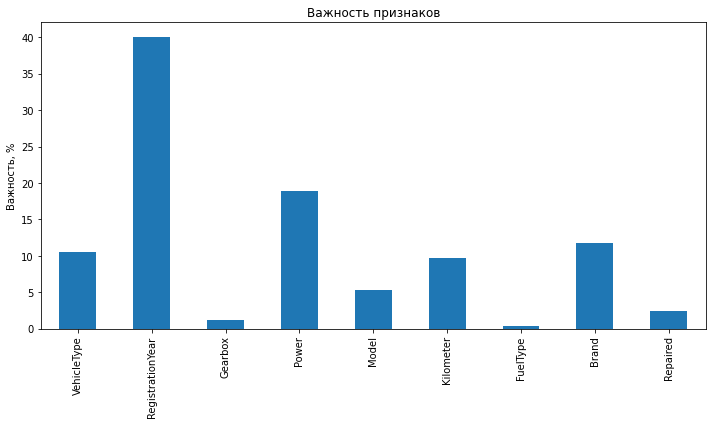

In [92]:
fig, ax = plt.subplots(figsize=(10,6))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [93]:
# model_skl_iris = RandomForestClassifier()
# model_skl_iris.fit(X = df_iris.drop(['target'], axis=1),
#                    y = df_iris['target'])

# skl_iris_imp = pd.Series(model_skl_iris.feature_importances_,
#                          df_iris.drop(['target'], axis=1).columns)

# fig, ax = plt.subplots(figsize=(16,14))
# skl_iris_imp.plot.bar(ax=ax)
# ax.set_title("Важность признаков")
# ax.set_ylabel('Важность')
# fig.tight_layout()

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей